# 決定木で訓練するプログラム

### 必要なライブラリのインポート

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from gensim import matutils
from gensim import corpora
import pickle
import sys
sys.path.append('../')
from util import util

### 定数宣言

In [2]:
ROOT_DIR = '.'
DATA_PATH = '/text'
FALSE_DATA_PATH = '/false'
DICTIONARY_PATH = '/Dictionary'
DICTIONARY_NAME = '/dictionary.txt'
LABEL_NAME = '/labels'
WORD_LIST = '/word_list'
WORD_LIST_FILENAME = '/word_list_file_name'

### ベクトルを１次元配列に変換するメソッド定義

In [3]:
def vec2dense(vec, num_terms):
    return list(matutils.corpus2dense([vec], num_terms=num_terms).T[0])

### 保存してた単語リストとラベルを読み込む

In [4]:
with open(ROOT_DIR+ROOT_DIR+DICTIONARY_PATH+WORD_LIST, "rb") as f:
    words = pickle.load(f)

with open(ROOT_DIR+ROOT_DIR+DICTIONARY_PATH+LABEL_NAME, "rb") as f:
    labels = pickle.load(f)

### 保存してた辞書を読み込む
warning出るけど、古いよってやつだからとりあえずシカト（でも毎回出るのはウザいな）

In [5]:
dictionary = corpora.Dictionary.load_from_text(ROOT_DIR+ROOT_DIR+DICTIONARY_PATH+DICTIONARY_NAME)

/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### 辞書の大きさの１次元配列を文章毎に作成する
http://kento1109.hatenablog.com/entry/2017/11/15/230909 \
https://qiita.com/hyo_07/items/ba3d53868b2f55ed9941
       

In [6]:
data_all = [vec2dense(dictionary.doc2bow(words[i]),len(dictionary)) for i in range(len(words))]

### １つの文章が以下のようなベクトルになる
頻出度をベクトルにした感じかな。まぁBoWだからそうか。\
TF-IDFをベクトルにしたものの方が割りかしいいかも\
後、頻出しないものは0って固定されてるのもいいのかな？＝＞単純に0がいいのか不明。少なくともword2vecのベクトルだとこれとは違うがマイナスとかの概念があって、それによって距離感とか上手く表現出来てる？（作成者も多分わかってない笑）
下記の標準化とは違うと思う

In [7]:
print(data_all[0])

[1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 5.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 5.0, 4.0, 1.0, 7.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 3.0, 1.0, 4.0, 2.0, 1.0, 7.0, 1.0, 5.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

### 元データである分ち書きデータと紐づけられるようにする

In [8]:
train_data = []
for data, i in enumerate(data_all):
    train_data.append([data, i])

### データを分ける
test_size ・・・　割り合い決める0.1か0.2がいいかな\
random_state　・・・　データ分割のランダム化を制御する値。詳しくは不明だが、これをNoneにするとランダムになり、実行の度にデータが変化する。（割合はtest_sizeに準ずる）つまりは分割する場所がランダムになる。\
shuffle　・・・　データをシャッフルするか\
返り値は名前の通り

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.1, random_state=1, shuffle=True)

### データを1次元配列に戻す

In [10]:
train_index = [data[0] for data in X_train]
X_train = [data[1] for data in X_train]
test_index = [data[0] for data in X_test]
X_test = [data[1] for data in X_test]

### データ標準化
色々説明必要だけど長いから参照: http://ailaby.com/scaler/ \
ここでのfitは学習ではなく、平均0,分散1にしてるみたいです。\
参照: http://learning.ikeay.net/entry/2016/07/19/140930

In [11]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [12]:
print(X_train_std[0])

[ 4.0728197  -0.22306088 -0.20411157 ... -0.27143745 -0.19669895
  3.70163689]


### モデル作成


In [13]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### モデル評価

In [14]:
score = clf.score(X_test, y_test)
print("{:.3g}".format(score))

0.795


### 標準化の効果
標準化すると単純に精度が上がる可能性がある。詳しくは標準化を調べればわかるかも

In [16]:
clf = DecisionTreeClassifier()
clf.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
score = clf.score(X_test_std, y_test)
print("{:.3g}".format(score))

0.78


### どれだけ何があってたか可視化
http://looseleaf0727.hatenablog.jp/entry/2017/12/04/234813

#### 正解と不正解の分類

<table>
    <tr>
        <th> </th>
        <th>True(正解)</th>
        <th>False(不正解)</th>
    </tr>
    <tr>
        <th>Positive(予想的中)</th>
        <td>TP</td>
        <td>FP</td>
    </tr>
    <tr>
        <th>Negative(予想外れ)</th>
        <td>TN</td>
        <td>FN</td>
   </tr>
        
</table>

<ul>
   <li>
        $$accuracy(精度) = \frac{TP + TN}{TP + FP + TN +  FN}$$
   </li>
   <li>
        $$precision(適合率) = \frac{TP}{TP + FP}$$
   </li>
   
   <li>
        $$recall(再現率) = \frac{TP}{TP+FN}$$
   </li>
   <li>
        $$f1-score(F-値) = 2\frac{Precision * Recall}{Precision+Recall}$$ 
   </li>
   <li>
        support ・・・　検証データ数
   </li>
    
</ul>

https://blog.amedama.jp/entry/2017/12/18/005311

In [18]:
from sklearn.metrics import classification_report
predict = clf.predict(X_test_std)
label = util.get_path_list(ROOT_DIR+ROOT_DIR+DATA_PATH)
for i, l in enumerate(label):
    print(i, l)
print(classification_report(y_test, predict, target_names=label))
    

0 movie-enter
1 it-life-hack
2 kaden-channel
3 topic-news
4 livedoor-homme
5 peachy
6 sports-watch
7 dokujo-tsushin
8 smax
                precision    recall  f1-score   support

   movie-enter       0.80      0.82      0.81        79
  it-life-hack       0.84      0.85      0.84        84
 kaden-channel       0.77      0.77      0.77        78
    topic-news       0.78      0.79      0.78        99
livedoor-homme       0.63      0.54      0.58        57
        peachy       0.52      0.63      0.57        76
  sports-watch       0.84      0.78      0.81        80
dokujo-tsushin       0.84      0.77      0.80       103
          smax       0.98      1.00      0.99        81

     micro avg       0.78      0.78      0.78       737
     macro avg       0.78      0.77      0.77       737
  weighted avg       0.79      0.78      0.78       737



### クラス毎の対比

In [19]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predict)

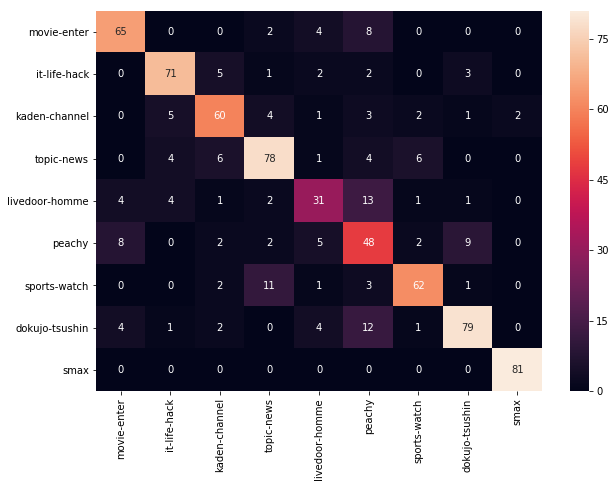

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index=label, columns = label)
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)

### 結果
ヒートマップで可視化してみると、livedoor-hommeとpeachyは似ているとわかる

### 実際、どんな文章を間違えて分類してしまったか見る(作成中)

### 元の文章との紐付ける為のファイル名リストを読み込む

In [22]:
with open(ROOT_DIR+ROOT_DIR+DICTIONARY_PATH+WORD_LIST_FILENAME, "rb") as f:
    word_list_file = pickle.load(f)

### 不正解フォルダを作成し、そこに予想したカテゴリ毎にフォルダを作成し、そこに正解データを入れていく
予想したカテゴリ内に実際の答えがある感じ\
フォルダのファイルを実際に見たり、TF-IDFで特徴語を抽出して、何の単語で誤判定をしてしまったかを考察出来る

In [23]:
import shutil,os
for i, pred in enumerate(predict):
    if not y_test[i] == pred:
        srcPath = ROOT_DIR+ROOT_DIR+DATA_PATH+"/"+label[y_test[i]]
        destPath = ROOT_DIR+FALSE_DATA_PATH
        if not os.path.isdir(destPath):
            os.mkdir(destPath)
        destPath = ROOT_DIR+FALSE_DATA_PATH + "/" + label[pred]
        if not os.path.isdir(destPath):
            os.mkdir(destPath)
        shutil.copyfile(srcPath+"/"+word_list_file[test_index[i]]+".txt"
                        , destPath+"/"+label[y_test[i]]+"_"+word_list_file[test_index[i]]+".txt")